In [1]:
import sys
import numpy as np
from astropy.io import fits
from astroscrappy import detect_cosmics
from matplotlib import pyplot as plt 
sys.path.append('aspired')

import twodspec
import standard

In [2]:
# Example data from SPRAT
# Hiltner102
sprat_data = fits.open('examples/v_s_20180703_65_1_0_2.fits')[0].data

aspired/twodspec.py:103: RuntimeWarning: invalid value encountered in log10
  np.log10(img),


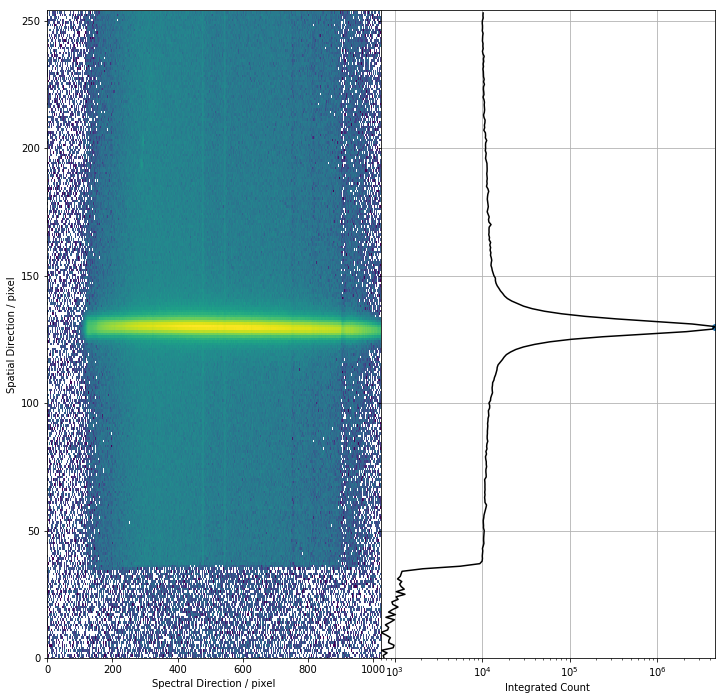

In [3]:
# (1) example of twodspec._find_peaks() with cosmic ray removal

# Set the spectral and spatial direction
Saxis = 1
Waxis = 0

# get the length in the spectral and spatial directions
spec_size = np.shape(sprat_data)[Waxis]
spatial_size = np.shape(sprat_data)[Saxis]

# the valid y-range of the chip (an array of int)
ydata = np.arange(spec_size)
ztot = np.sum(sprat_data, axis=Saxis)

peaks_y, heights_y = twodspec._find_peaks(detect_cosmics(sprat_data)[1], spec_size, spatial_size, ydata, ztot, f_height=0.2, display=True)

aspired/twodspec.py:331: RuntimeWarning: invalid value encountered in log10
  np.log10(img),


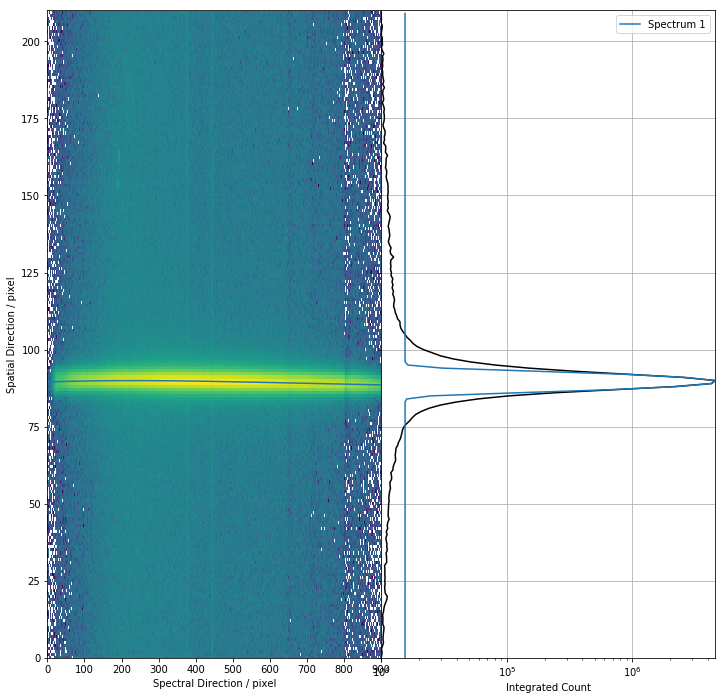

In [4]:
# (3) example of twodspec.ap_trace() with cosmic ray removal, selecting the 7 brightest spectra
#     in the pixel range covered by spatial_mask and spec_mask.
#     The 6th and 7th ones failed, error messages are printed but the code continues to run.

spec_mask = np.arange(40,250)
spatial_mask = np.arange(100,1000)

my, my_sigma = twodspec.ap_trace(sprat_data, nsteps=20, Saxis=1, spatial_mask=spatial_mask, spec_mask=spec_mask,
                                cosmic=True, n_spec=1, recenter=False, prevtrace=(0, ), 
                                fittype='spline', bigbox=8, silence=True, display=True)

In [5]:
# Optimal extracting spectrum by summing over the aperture along the trace
# my[0] is a special cases where skysep has to be increased to avoid crowding
spec, sky, err = twodspec.ap_extract(
    sprat_data,
    my[0],
    apwidth=20,
    trace_sigma = my_sigma[0],
    spatial_mask=spatial_mask,
    spec_mask=spec_mask,
    display=True)

spec_mask contains elements other than [0, 1, 0., 1., True, False], the entire range in the spectraldirection is used.
spatial_mask contains elements other than [0, 1, 0., 1., True, False], the entire range in the spatialdirection is used.


IndexError: arrays used as indices must be of integer (or boolean) type

In [ ]:
standard._read_standard('hiltner102' ,'irafirs', cutoff=0.4, ftype='flux', display=True)

In [ ]:
# Get the standard
standard_wave, standard_flux = standard._read_standard('hiltner102' ,'irafirs', cutoff=0.4, ftype='flux', display=False)

# Get the sensitivity curves with and without smoothing
wave = np.arange(len(spec))*4.45+4000.
sencurve_smoothed = standard.get_sencurve(
    wave, spec, 'hiltner102' ,'irafirs', exp_time=60, cutoff=0.4, slength=11, sorder=2, display=True)


In [ ]:
sencurve_not_smoothed = standard.get_sencurve(
    wave, spec, 'hiltner102' ,'irafirs', exp_time=60., cutoff=0.4, smooth=False, display=True)

In [ ]:
# Plot the three spectra
plt.figure(figsize=(10,10))
plt.plot(standard_wave, standard_flux, label='Absolute standard flux')
plt.plot(wave, spec / 60.* sencurve_smoothed(wave), label='Sensitivity curve with smoothing')
plt.plot(wave, spec / 60.* sencurve_not_smoothed(wave), label='Sensitivity curve without smoothing')
plt.xlabel(r'Wavelength / $\AA$')
plt.ylabel(r'Flux / ergs cm$^{-2}$ s$^{-1} \AA^{-1}$')
plt.ylim(min(standard_flux)*0.95, max(standard_flux)*1.05)
plt.grid()
plt.legend()